# 전처리 가설 검증
- df_train + weather/oil 제외 추가데이터
- 모든 나라에 대해서 진행

# Setting

In [1]:
# Import Libraries & Functions
from utility import *

In [2]:
# Turn off warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Visualization Setting
color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
# Data directory
root = os.path.join(os.getcwd(), 'DATA')

### Merging dataframes

In [5]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Import Data

In [6]:
df_train = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
df_weather_kr = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
df_cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))

----

# Basic Dataframe
df_train
- 날짜 데이터 수정 (REG_DATE to 'year', 'week')
- 미사용 컬럼 drop (P_TYPE)

In [7]:
df_train = df_train.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                            [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

In [8]:
set_week(df_train, 'REG_DATE')
check_week(df_train)

missing 0 values


In [9]:
df_train.drop(columns = ['P_TYPE'], inplace=True)

----

# Baseline Dataframe
**df0_base**:  
- One hot encoding on categorical features

## Preprocess

In [10]:
df0_base = df_train.copy()

### One hot encoding

In [11]:
# P_IMPORT_TYPE
import_type_list = set()
for tmp in df0_base.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)
for name in import_type_list:
    df0_base[name] = 0
    df0_base.loc[df0_base['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [12]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

### Drop Columns

In [13]:
df0_base.drop(columns = ['P_IMPORT_TYPE'], inplace=True)

## Train

#### Numerical Features

In [14]:
numerical_columns = ['P_PRICE', 'year', 'week']

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


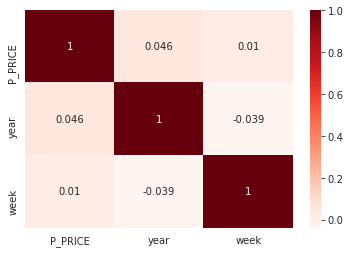

In [15]:
#Using Pearson Correlation
plt.figure(figsize=(6, 4))
cor = df0_base[numerical_columns].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

날짜 데이터('year', 'week')는 P_PRICE 결정에 큰 영향을 미치지 않음을 확인 할 수 있다  
다만, 데이터를 추가하는 기준으로 사용해야하므로 인덱스로 가져가준다

Model Training Complete!


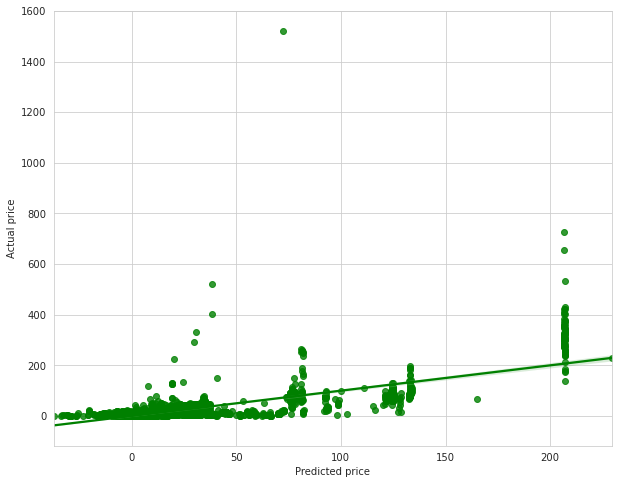

>> RMSE train = 14.252151846665338
>> RMSE validation = 912703084.9382205
-------------------------------------------------


In [16]:
model0, plt0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

In [17]:
save_img(plt0, '3-1. model0')

In [18]:
# plot feature importance
features = print_importance(model0, df0_base, [])

-------------------------------------------------
총 625 개


----

# Adding Columns
- 어종별 수 컬럼 추가
- 수입용도 수 컬럼 추가
- 가공여부 컬럼 추가

In [ ]:
df1_add_columns = df_train.copy()

## Preprocess

#### Add columns

In [ ]:
added_columns = []

In [ ]:
def get_cnt(df, column, new_column):
    value_dict = {}
    for name, value in zip(df[column].value_counts().index, df[column].value_counts()):
        value_dict[name] = value
    def value(col):
        return value_dict[col]

    df[new_column] = df[column].apply(value)

In [ ]:
# 제조국 수 컬럼 추가
get_cnt(df1_add_columns, 'CTRY_1', 'ctry1_cnt')
added_columns.append('ctry1_cnt')

In [ ]:
# 수출국 수 컬럼 추가
get_cnt(df1_add_columns, 'CTRY_2', 'ctry2_cnt')
added_columns.append('ctry2_cnt')

In [ ]:
# 수입용도 수 컬럼 추가
get_cnt(df1_add_columns, 'P_PURPOSE', 'purpose_cnt')
added_columns.append('purpose_cnt')

In [ ]:
# 분류 수 컬럼 추가
get_cnt(df1_add_columns, 'CATEGORY_1', 'category1_cnt')
added_columns.append('category1_cnt')

In [ ]:
# 어종 수 컬럼 추가 
get_cnt(df1_add_columns, 'CATEGORY_2', 'category2_cnt')
added_columns.append('category2_cnt')

In [ ]:
# 상세어종별 수 컬럼 추가
get_cnt(df1_add_columns, 'P_NAME', 'name_cnt')
added_columns.append('name_cnt')

In [ ]:
# 가공 여부 컬럼 추가
df1_add_columns['is_processed'] = (df1_add_columns['CTRY_1'] != df1_add_columns['CTRY_2'])
added_columns.append('is_processed')

In [ ]:
# 수입형태
import_type_list = set()
for tmp in df1_add_columns.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)
for name in import_type_list:
    df1_add_columns[name] = 0
    df1_add_columns.loc[df1_add_columns['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [ ]:
# 수입형태 수 컬럼 추가
df1_add_columns['import_cnt'] = 0
for i, row in df1_add_columns.iterrows():
    for name in import_type_list:
        if row[name] == 1:
            df1_add_columns.at[i, 'import_cnt'] += 1
added_columns.append('import_cnt')

#### One hot encoding

In [ ]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df1_add_columns = pd.get_dummies(df1_add_columns, columns=one_hot)

### Drop Columns

In [ ]:
df1_add_columns.drop(columns = ['P_IMPORT_TYPE'], inplace=True)

## Check

In [ ]:
df1_add_columns['name_cnt'].describe()

In [ ]:
df1_add_columns['import_cnt'].value_counts()

In [ ]:
df1_add_columns['is_processed'].value_counts()

## Train

In [ ]:
model1 = train_model(df1_add_columns.drop(columns=['P_PRICE']), df1_add_columns['P_PRICE'])

In [ ]:
t = print_importance(model1, df1_add_columns, added_columns)

- name_cnt와 import_Cnt 는 중요도가 꽤나 높다
- 그 외는 작다
- 그럼에도 변수 추가를 통해 모델 정확도가 상승한 것을 확인할 수 있다

----

# Detecting Anomaly & Standardization

In [ ]:
df2_transformed = df1_add_columns.copy()

## Univariate Analysis

In [ ]:
price_scale = StandardScaler().fit_transform(df2_transformed['P_PRICE'][:,np.newaxis]);
low_range = price_scale[price_scale[:,0].argsort()][:10]
high_range= price_scale[price_scale[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(*low_range)
print('\nouter range (high) of the distribution:')
print(*high_range)

- lower range 는 0에 가까워 크게 신경 쓸 필요 없다
- higher range의 경우 상당히 큰 값들이 있음을 확인할 수 있다
- 이 중 특히 마지막 3 ~ 6개는 그 값이 급증하므로 이상치로 생각할 수 있다

## Bivariate Analysis

- name_cnt
- import_cnt

추가한 numerical feature 중 중요도가 높았던 두 변수에 대해 bivariate analysis를 진행한다

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='name_cnt', y='P_PRICE', data=df2_transformed, color='mediumseagreen')
plt.title("name_cnt",fontsize=title_size)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='import_cnt', y='P_PRICE', data=df2_transformed, color='mediumseagreen')
plt.title("import_cnt",fontsize=title_size)
plt.show()

앞서 이상치가 6개가 될 것이라고 예상하였는데,  
역시나 공통적으로 P_PRICE가 약 500 이상인 값이 눈에 띄게 크다  
따라서 해당 row는 anamoly 로 취급한다

In [ ]:
# Drop Row
df2_transformed = df2_transformed[df2_transformed['P_PRICE'] < 500]

## Standardization

Numerical feature 에 대해서 정규화를 진행해야한다
- P_PRICE
- ctry1_cnt
- ctry2_cnt
- purpose_cnt
- name_cnt
- category1_cnt
- category2_cnt
- import_cnt

이 중, target value 인 P_PRICE와 함께 앞서 확인한 우선순위가 높은 name_cnt, import_cnt에 대해 진행한다

#### P_PRICE

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['P_PRICE'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['P_PRICE'], plot=plt)

plt.show()

- Peakedness
- Positive Skewedness
- Doesn't follow the diagonal line

In [ ]:
df2_transformed['P_PRICE'] = np.log1p(df2_transformed['P_PRICE'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['P_PRICE'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['P_PRICE'], plot=plt)

plt.show()

#### name_cnt

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['name_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['name_cnt'], plot=plt)

plt.show()

In [ ]:
df2_transformed['name_cnt'] = np.log1p(df2_transformed['name_cnt'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['name_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['name_cnt'], plot=plt)

plt.show()

#### import_cnt

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['import_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['import_cnt'], plot=plt)

plt.show()

In [ ]:
df2_transformed['import_cnt'] = np.log1p(df2_transformed['import_cnt'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['import_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['import_cnt'], plot=plt)

plt.show()

## Train

In [ ]:
model2 = train_model(df2_transformed.drop(columns=['P_PRICE']), df2_transformed['P_PRICE'])

----

# Dropping Columns
- df3_drop_1 : CATEGORY_2, P_NAME drop
- df4_drop_2 : CATEGORY_1, CATEGORY_2 drop
- df5_drop_3 : CATEOGRY_2 drop

In [ ]:
df3_drop_1 = df2_transformed.copy()
df4_drop_2 = df2_transformed.copy()
df5_drop_3 = df2_transformed.copy()

## Preprocess

In [ ]:
# Drop columns
drop_column = []
for column in df3_drop_1.columns:
    if 'CATEGORY_2' in column or 'P_NAME' in column:
        drop_column.append(column)
df3_drop_1.drop(columns=drop_column, axis=1, inplace=True)

In [ ]:
# Drop columns
drop_column = []
for column in df4_drop_2.columns:
    if 'CATEGORY_' in column:
        drop_column.append(column)
df4_drop_2.drop(columns=drop_column, axis=1, inplace=True)

In [ ]:
# Drop columns
drop_column = []
for column in df5_drop_3.columns:
    if 'CATEGORY_2' in column:
        drop_column.append(column)
df5_drop_3.drop(columns=drop_column, axis=1, inplace=True)

## Train

In [ ]:
print("===========DROP NONE============")
model2 = train_model(df2_transformed.drop(columns=['P_PRICE']), df2_transformed['P_PRICE'])

In [ ]:
print("===========DROP CATEGORY_2 & P_NAME============")
model3 = train_model(df3_drop_1.drop(columns=['P_PRICE']), df3_drop_1['P_PRICE'])

In [ ]:
print("===========DROP CATEGORY_1, CATEGORY_2============")
model4 = train_model(df4_drop_2.drop(columns=['P_PRICE']), df4_drop_2['P_PRICE'])

In [ ]:
print("===========DROP CATEGORY_2============")
model5 = train_model(df5_drop_3.drop(columns=['P_PRICE']), df5_drop_3['P_PRICE'])

결론적으로 분류와 관련된 변수는 Drop 하지 않는 것이 더 효과적임을 알 수 있다

----

# Adding Data

In [ ]:
df6_add_data = merge_df([df2_transformed, df_oil, df_weather_kr, df_cpi])

## Preprocess
추가한 데이터 모두 numerical feature 이므로 위와 같이 정규화를 해준다
- oil
- wind_kr
- temperature_kr
- water_temp_kr
- cpi_total
- cpi_fish

In [ ]:
added_columns = ['oil', 'wind_kr', 'temperature_kr', 'water_temp_kr', 'cpi_total', 'cpi_fish']

#### oil

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['oil'], plot=plt)

plt.show()

In [ ]:
df6_add_data['oil'] = np.log1p(df6_add_data['oil'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['oil'], plot=plt)

plt.show()

#### wind_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['wind_kr'], plot=plt)

plt.show()

In [ ]:
df6_add_data['wind_kr'] = np.log1p(df6_add_data['wind_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['wind_kr'], plot=plt)

plt.show()

#### temperature_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['temperature_kr'], plot=plt)

plt.show()

In [ ]:
df6_add_data['temperature_kr'] = np.log1p(df6_add_data['temperature_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['temperature_kr'], plot=plt)

plt.show()

#### water_temp_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['water_temp_kr'], plot=plt)

plt.show()

In [ ]:
df6_add_data['water_temp_kr'] = np.log1p(df6_add_data['water_temp_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['water_temp_kr'], plot=plt)

plt.show()

#### cpi_total

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['cpi_total'], plot=plt)

plt.show()

In [ ]:
df6_add_data['cpi_total'] = np.log1p(df6_add_data['cpi_total'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['cpi_total'], plot=plt)

plt.show()

#### cpi_fish

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['cpi_fish'], plot=plt)

plt.show()

In [ ]:
df6_add_data['cpi_fish'] = np.log1p(df6_add_data['cpi_fish'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df6_add_data['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df6_add_data['cpi_fish'], plot=plt)

plt.show()

## Train

In [ ]:
model6 = train_model(df6_add_data.drop(columns=['P_PRICE']), df6_add_data['P_PRICE'])

In [ ]:
t = print_importance(model6, df6_add_data, added_columns)

- 순위가 별로 높지 않으며, 모델 성능이 크게 개선되지 않음을 발견할 수 있다
- 다만, 몇 없는 numerical feature 이므로 파생 변수를 추가하는 방향으로 고려해볼 수 있을 것이다

----

# Feature Selection (by Correlation)

In [ ]:
df7_feature_selection = df_train.copy()

## Preprocess

In [ ]:
# 파생변수 추가
get_cnt(df7_feature_selection, 'CTRY_1', 'ctry1_cnt')  # 제조국 수 컬럼 추가
get_cnt(df7_feature_selection, 'CTRY_2', 'ctry2_cnt')  # 수출국 수 컬럼 추가
get_cnt(df7_feature_selection, 'P_PURPOSE', 'purpose_cnt')  # 수입용도 수 컬럼 추가
get_cnt(df7_feature_selection, 'CATEGORY_1', 'category1_cnt')
get_cnt(df7_feature_selection, 'CATEGORY_2', 'category2_cnt')
get_cnt(df7_feature_selection, 'P_NAME', 'name_cnt')  # 어종별 수 컬럼 추가
df7_feature_selection['is_processed'] = (df7_feature_selection['CTRY_1'] != df7_feature_selection['CTRY_2'])  # 가공 여부 컬럼 추가

In [ ]:
# 파생변수 추가
df7_feature_selection['import_cnt'] = 0
for name in import_type_list:
    df7_feature_selection.loc[df7_feature_selection['P_IMPORT_TYPE'].str.contains(name, regex=False), 'import_cnt'] += 1

In [ ]:
# 이상치 제거
df7_feature_selection = df7_feature_selection[df7_feature_selection['P_PRICE'] < 500]

In [ ]:
# 데이터 추가
df7_feature_selection = merge_df([df7_feature_selection, df_oil, df_weather_kr, df_cpi])

In [ ]:
# 정규화
df7_feature_selection['P_PRICE'] = np.log1p(df7_feature_selection['P_PRICE'])
added = added_columns + ['name_cnt', 'import_cnt']
for column in added:
    df7_feature_selection[column] = np.log1p(df7_feature_selection[column])

## Grouping by Correlation
- P_PRICE 와 상관관계가 높은 변수 찾기
- 서로 상관관계가 높은 변수 찾기

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(15,12))
cor = df7_feature_selection.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

서로간 상관계수가 큰 변수
- ctry1_cnt & ctry2_cnt
    - ctry1_cnt 사용 (ctry2_cnt 제거)  
- year & oil & cpi_total & cpi_fish
    - cpi_total 사용 (cpi_fish 제거)  
    - cpi_fish / cpi_total 사용
    - oil 삭제
- week & temperature_kr & water_temp_kr
    - temperature_kr & water_temp_kr 평균 사용
    - temperature_kr & water_temp_kr & wind_kr 평균 사용

In [ ]:
# 검증용 변수 생성
df7_feature_selection['temp_1'] = (df7_feature_selection['temperature_kr'] + df7_feature_selection['water_temp_kr']) / 2
df7_feature_selection['temp_2'] = (df7_feature_selection['temperature_kr']
                                   + df7_feature_selection['water_temp_kr']
                                   + df7_feature_selection['wind_kr']) / 3
df7_feature_selection['cpi'] = df7_feature_selection['cpi_fish'] / df7_feature_selection['cpi_total']

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(15,12))
cor = df7_feature_selection[['P_PRICE', 'oil', 'wind_kr', 'temperature_kr', 'water_temp_kr', 'cpi_total', 'cpi_fish', 'temp_1', 'temp_2', 'cpi']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

결론
- cpi_total 사용
- 기온과 수온의 평균 사용

In [ ]:
df7_feature_selection['temp_kr'] = (df7_feature_selection['temperature_kr'] + df7_feature_selection['water_temp_kr']) / 2

In [ ]:
df7_feature_selection.drop(columns=['ctry2_cnt', 'cpi_fish', 'temperature_kr', 'water_temp_kr', 'oil', 'temp_1', 'temp_2', 'cpi'], axis=1, inplace=True)

## One Hot Encoding & Dropping

In [ ]:
for name in import_type_list:
    df7_feature_selection[name] = 0
    df7_feature_selection.loc[df7_feature_selection['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [ ]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df7_feature_selection = pd.get_dummies(df7_feature_selection, columns=one_hot)

In [ ]:
df7_feature_selection.drop(columns = 'P_IMPORT_TYPE', inplace=True)

## Train

In [ ]:
model7 = train_model(df7_feature_selection.drop(columns=['P_PRICE']), df7_feature_selection['P_PRICE'])

In [ ]:
t = print_importance(model7, df7_feature_selection, ['temp_kr'])

정확도가 감소한 것을 확인할 수 있다  
그러나 다중공선성 문제를 피하기 위해서는 어쩔 수 없다

----
# Grouping (by Frequency)
1% / 5% 이하로 등장하는 카테고리의 경우 동일한 것으로 취급한다

In [ ]:
df8_grouping = df_train.copy()

## Preprocess

In [ ]:
# 파생변수 추가
get_cnt(df8_grouping, 'CTRY_1', 'ctry1_cnt')  # 제조국 수 컬럼 추가
get_cnt(df8_grouping, 'CTRY_2', 'ctry2_cnt')  # 수출국 수 컬럼 추가
get_cnt(df8_grouping, 'P_PURPOSE', 'purpose_cnt')  # 수입용도 수 컬럼 추가
get_cnt(df8_grouping, 'CATEGORY_1', 'category1_cnt')
get_cnt(df8_grouping, 'CATEGORY_2', 'category2_cnt')
get_cnt(df8_grouping, 'P_NAME', 'name_cnt')  # 어종별 수 컬럼 추가
df8_grouping['is_processed'] = (df8_grouping['CTRY_1'] != df8_grouping['CTRY_2'])  # 가공 여부 컬럼 추가

In [ ]:
# 파생변수 추가
df8_grouping['import_cnt'] = 0
for name in import_type_list:
    df8_grouping.loc[df8_grouping['P_IMPORT_TYPE'].str.contains(name, regex=False), 'import_cnt'] += 1

In [ ]:
# 이상치 제거
df8_grouping = df8_grouping[df8_grouping['P_PRICE'] < 500]

In [ ]:
# 데이터 추가
df8_grouping = merge_df([df8_grouping, df_oil, df_weather_kr, df_cpi])

In [ ]:
# 정규화
df8_grouping['P_PRICE'] = np.log1p(df8_grouping['P_PRICE'])
added = added_columns + ['name_cnt', 'import_cnt']
for column in added:
    df8_grouping[column] = np.log1p(df8_grouping[column])

## Grouping

In [ ]:
length = len(df8_grouping)

In [ ]:
percent = (df8_grouping['CTRY_1'].value_counts() / length)
ctry1_group = percent[percent <= 0.01].index
for ctry1 in ctry1_group:
    df8_grouping = df8_grouping.replace(ctry1, '기타')

In [ ]:
percent = (df8_grouping['CTRY_2'].value_counts() / length)
ctry2_group = percent[percent <= 0.01].index
for ctry2 in ctry2_group:
    df8_grouping = df8_grouping.replace(ctry2, '기타')

In [ ]:
percent = (df8_grouping['CATEGORY_1'].value_counts() / length)
cat1_group = percent[percent < 0.05].index
for cat1 in cat1_group:
    df8_grouping = df8_grouping.replace(cat1, '기타')

In [ ]:
percent = (df8_grouping['CATEGORY_2'].value_counts() / length)
cat2_group = percent[percent < 0.01].index
for cat2 in cat2_group:
    df8_grouping = df8_grouping.replace(cat2, '기타')

In [ ]:
percent = (df8_grouping['P_NAME'].value_counts() / length)
name_group = percent[percent < 0.01].index
for name in name_group:
    df8_grouping = df8_grouping.replace(name, '기타')

## One Hot Encoding & Dropping

In [ ]:
for name in import_type_list:
    df8_grouping[name] = 0
    df8_grouping.loc[df8_grouping['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [ ]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df8_grouping = pd.get_dummies(df8_grouping, columns=one_hot)

In [ ]:
df8_grouping.drop(columns = 'P_IMPORT_TYPE', inplace=True)

## Train

In [ ]:
model8 = train_model(df8_grouping.drop(columns=['P_PRICE']), df8_grouping['P_PRICE'])

In [ ]:
added_columns = []
for column in df8_grouping.columns:
    if '기타' in column:
        added_columns.append(column)

In [ ]:
t = print_importance(model8, df8_grouping, added_columns)

새로운 변수의 순위는 높으나 모델의 정확도는 감소했다

----

# Final DF

In [ ]:
df_final = df_train.copy()

## Preprocess

In [ ]:
# 파생변수 추가
get_cnt(df_final, 'CTRY_1', 'ctry1_cnt')  # 제조국 수 컬럼 추가
get_cnt(df_final, 'P_PURPOSE', 'purpose_cnt')  # 수입용도 수 컬럼 추가
get_cnt(df_final, 'CATEGORY_1', 'category1_cnt')
get_cnt(df_final, 'CATEGORY_2', 'category2_cnt')
get_cnt(df_final, 'P_NAME', 'name_cnt')  # 어종별 수 컬럼 추가
df_final['is_processed'] = (df_final['CTRY_1'] != df_final['CTRY_2'])  # 가공 여부 컬럼 추가

In [ ]:
# 파생변수 추가
df_final['import_cnt'] = 0
for name in import_type_list:
    df_final[name] = 0
    df_final.loc[df_final['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1    
    df_final.loc[df_final['P_IMPORT_TYPE'].str.contains(name, regex=False), 'import_cnt'] += 1

In [ ]:
# 이상치 제거
df_final = df_final[df_final['P_PRICE'] < 500]

In [ ]:
# 데이터 추가
df_final = merge_df([df_final, df_oil, df_weather_kr, df_cpi])

In [ ]:
# 정규화
df_final['P_PRICE'] = np.log1p(df_final['P_PRICE'])
added = ['name_cnt', 'import_cnt']
for column in added:
    df_final[column] = np.log1p(df_final[column])

In [ ]:
# Grouping
df_final['temp_kr'] = (df_final['temperature_kr'] + df_final['water_temp_kr']) / 2

In [ ]:
# 전처리 가설 검증 3-2 에서 사용할 Dataframe 생성
df_tosave = df_final.copy()

In [ ]:
# One Hot Encoding
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df_final = pd.get_dummies(df_final, columns=one_hot)

In [ ]:
# Drop
df_final.drop(columns=['cpi_fish', 'temperature_kr', 'water_temp_kr', 'P_IMPORT_TYPE'], axis=1, inplace=True)
df_tosave.drop(columns=['cpi_fish', 'temperature_kr', 'water_temp_kr', 'P_IMPORT_TYPE'], axis=1, inplace=True)

## Train

In [ ]:
model = train_model(df_final.drop(columns=['P_PRICE']), df_final['P_PRICE'])

In [ ]:
final_fs = print_importance(model, df_final, [])

## Save

In [ ]:
df_final.to_csv(os.path.join(root, "preprocessed_train_1.csv"), encoding='utf-8', index=False)
df_tosave.to_csv(os.path.join(root, "preprocessed_train_notencoded.csv"), encoding='utf-8', index=False)